In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [7]:
train70M, val70M = torch.load("pythia-70M-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train160M, val160M = torch.load("pythia-160M-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train410M, val410M = torch.load("pythia-410M-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train1B, val1B   = torch.load("pythia-1B-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train1B4, val1B4 = torch.load("pythia-1.4B-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train2B8, val2B8 = torch.load("pythia-2.8B-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")
train6B9, val6B9 = torch.load("pythia-6.9B-deduped (Training, Validation) data_ bs=8, nbatches=500, length=50).pt")

In [8]:
def compute_fpr_tpr_thresholds(valuestraining, valuesvalidation, st, end):
    not_nan = torch.logical_not(torch.logical_or( torch.isnan(valuestraining),torch.isnan(valuesvalidation)))
    valuestraining = valuestraining[not_nan]
    valuesvalidation = valuesvalidation[not_nan]

    y_scores =  torch.cat((valuestraining, valuesvalidation))
    y_scores = y_scores-st
    y_scores = y_scores/end
    y_true   = [1 for _ in range(len(valuestraining))] + [0 for _ in range(len(valuesvalidation))]

    return roc_curve(y_true,y_scores)

In [12]:
valid_data

[tensor([0.0640, 0.0764, 0.0874,  ..., 0.1024, 0.0784, 0.0742]),
 tensor([0.0518, 0.0930, 0.0621,  ..., 0.0515, 0.0051, 0.0661]),
 tensor([0.0420, 0.0690, 0.0542,  ..., 0.0481, 0.0474, 0.0641]),
 tensor([0.0127, 0.0386, 0.0124,  ..., 0.0744, 0.0647, 0.0578]),
 tensor([0.0619, 0.0413, 0.0085,  ..., 0.0291, 0.0445, 0.0497]),
 tensor([0.0212, 0.0593, 0.0156,  ..., 0.0496, 0.0704, 0.0825]),
 tensor([0.0612, 0.0424, 0.0475,  ..., 0.0597, 0.0630, 0.0438])]

tensor(0.0002) tensor(4.1326)


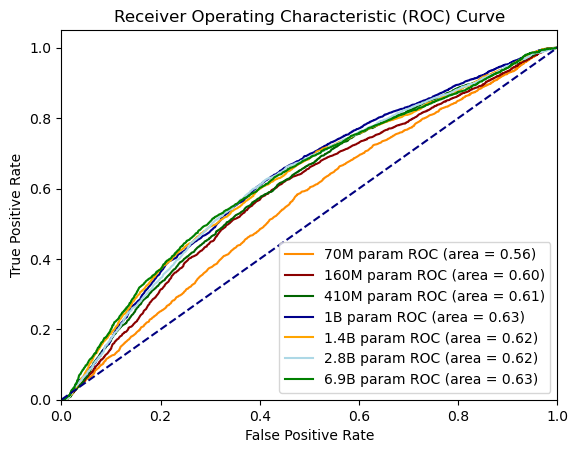

In [26]:

from sklearn.metrics import roc_curve, auc
train_data = [(train70M, val70M), (train160M, val160M), (train410M, val410M), (train1B, val1B), (train1B4, val1B4), (train2B8, val2B8), (train6B9, val6B9)]


st = min([ min(min(t),min(u)) for t,u in train_data])
end = max([ max(max(t),max(u)) for t,u in train_data]) - min([ min(min(t),min(u)) for t,u in train_data])
print(st,end)


fpr = []
tpr = []
thresholds = []
auc_res = []
colors = ['darkorange', 'darkred', 'darkgreen', 'darkblue', 'orange', 'lightblue', 'green']
names =["70M", "160M", "410M", "1B", "1.4B", "2.8B", "6.9B"]

for i in range(len(train_data)):
    f, t, th = compute_fpr_tpr_thresholds(train_data[i][0], train_data[i][1], st, end)
    auc_res.append(auc(f, t))
    fpr.append(f)
    tpr.append(t)
    thresholds.append(th)
    

# Plot the ROC curve
for i in range(len(train_data)):    
    plt.plot(fpr[i], tpr[i], color=colors[i], label=names[i]+' param ROC (area = %0.2f)' % auc_res[i])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc all models.png")

In [60]:
# def compute_how_many(c, training, validation):
#     trainlength = len(training[training>=c])
#     vallength   = len(validation[validation>= c ])
#     return (vallength+trainlength)

# def compute_threshold(c, training, validation):
#     trainlength = len(training[training>=c])
#     vallength   = len(validation[validation>= c ])
#     return trainlength/(vallength+trainlength)
# def plot_fract_in_training_wrt_model_size(threshold):
#     model_sizes = [410, 1000, 1400, 2800, 6900] # in millions

#     # Example performance metric values for each model size
#     # Replace with your own values
#     performance = [compute_threshold(threshold, train410M, val410M), 
#                    compute_threshold(threshold, train1B, val1B), 
#                    compute_threshold(threshold, train1B4, val1B4), 
#                    compute_threshold(threshold, train2B8, val2B8),
#                    compute_threshold(threshold, train6B9, val6B9),
#                   ]

#     plt.title("Threshold attack success vs Model Size")
#     plt.xlabel("Model Size (Millions of Parameters)")
#     plt.ylabel("# in training set/(# in training and val sets)")
#     plt.plot(model_sizes, performance, marker='o')


#     thresholds = np.arange(-0.05,-0.00001,0.00001)
# # length410M = [compute_how_many(t, train410M, val410M) for t in thresholds]
# # prob410M = [compute_threshold(t, train410M, val410M) for t in thresholds]

# length1B = [compute_how_many(t, train1B, val1B) for t in thresholds]
# prob1B = [compute_threshold(t, train1B, val1B) for t in thresholds]

# length1B4 = [compute_how_many(t, train1B4, val1B4) for t in thresholds]
# prob1B4 = [compute_threshold(t, train1B4, val1B4) for t in thresholds]


# length2B8 = [compute_how_many(t, train2B8, val2B8) for t in thresholds]
# prob2B8 = [compute_threshold(t, train2B8, val2B8) for t in thresholds]

# length6B9 = [compute_how_many(t, train6B9, val6B9) for t in thresholds]
# prob6B9 = [compute_threshold(t, train6B9, val6B9) for t in thresholds]